In [ ]:

%pip install tensorflow==2.17.0
%pip install keras==3.4.1
%pip install tf_keras==2.17.0
%pip install numpy==1.26.4
%pip install scikit-learn==1.3.2
%pip install matplotlib==3.7.1
%pip install joblib==1.4.2
%pip install opencv-python==4.10.0.84

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
import joblib

In [3]:
data_dir = r"E:\Lung Cancer\LungCANCER\test_images" 
classes = {'Benign case', 'Malignant case', 'Normal case'}
images = []
labels = []
image_size = 224
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)

    for filename in os.listdir(class_dir):
        image_path = os.path.join(class_dir, filename)

        image = cv2.imread(image_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        images.append(image)
        labels.append(class_name)
label_dict = {"Benign case": 0, "Malignant case": 1, "Normal case": 2}
encoded_labels = [label_dict[label] for label in labels]
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.30, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10/(1-0.10), random_state=123)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)


print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))
print("Validation data size:", len(X_val))

Training data size: 681
Testing data size: 330
Validation data size: 86


In [4]:
X_train.shape

(681, 224, 224, 3)

In [5]:
X_train, X_test, X_val= X_train / 255.0, X_test / 255.0, X_val / 255.0 # Rescale it to 0-1

In [7]:
from collections import Counter

train_class_counts = Counter()

for image_path in y_train:
    class_name = str(image_path).split("/")[0]
    train_class_counts[class_name] += 1

print("Number of training images per class:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

Number of training images per class:
2: 250
1: 347
0: 84


In [9]:
test_class_counts = Counter()

for image_path in y_test:
    class_name = str(image_path).split("/")[0]
    test_class_counts[class_name] += 1

print("Number of testing images per class:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Number of testing images per class:
0: 31
1: 166
2: 133


In [10]:
test_class_counts = Counter()

for image_path in y_val:
    class_name = str(image_path).split("/")[0]
    test_class_counts[class_name] += 1

print("Number of validation images per class:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Number of validation images per class:
0: 5
1: 48
2: 33


As observed from the split data, we can conclude that there are imbalance in class

Custom_CNN-RF Model

In [11]:
from tensorflow.keras import layers, models, regularizers, initializers, Input

initializer = initializers.HeNormal(seed=123)
input_layer = Input(shape=(image_size, image_size, 3))  

x = layers.Conv2D(128, (5,5), strides=(2,2), activation='relu')(input_layer)
x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                  kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2), strides=(2,2))(x)

x = layers.Conv2D(32, (3,3), padding='same', activation='relu',
                  kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2), strides=(1,1))(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5, seed=123)(x)

output_layer = layers.Dense(3, activation='softmax')(x)

cnn_model = models.Model(inputs=input_layer, outputs=output_layer)


In [12]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 110, 110, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 54, 54, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 27, 27, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,640,803 (21.52 MB)

 Trainable params: 5,640,803 (21.52 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
learning_rate = 0.001 
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) 

cnn_model.compile(
                  loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=["accuracy"]
)

history = cnn_model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=20, shuffle = True, batch_size=16)  

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.5051 - loss: 2.7004 - val_accuracy: 0.7093 - val_loss: 1.6020
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.6436 - loss: 1.5645 - val_accuracy: 0.8488 - val_loss: 0.9946
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7201 - loss: 1.1328 - val_accuracy: 0.8953 - val_loss: 0.6652
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.8263 - loss: 0.7935 - val_accuracy: 0.9302 - val_loss: 0.5376
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.8837 - loss: 0.6075 - val_accuracy: 0.9651 - val_loss: 0.3581
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9248 - loss: 0.4618 - val_accuracy: 0.9767 - val_loss: 0.2958
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.9540 - loss: 0.3567 - val_accuracy: 0.9651 - val_loss: 0.2767
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9432 - loss: 0.3112 - val_accuracy: 0

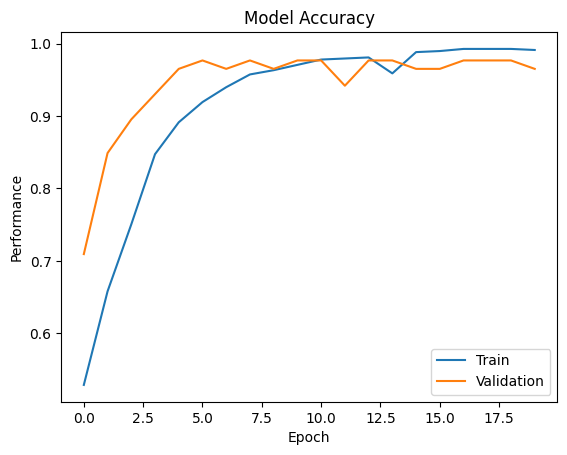

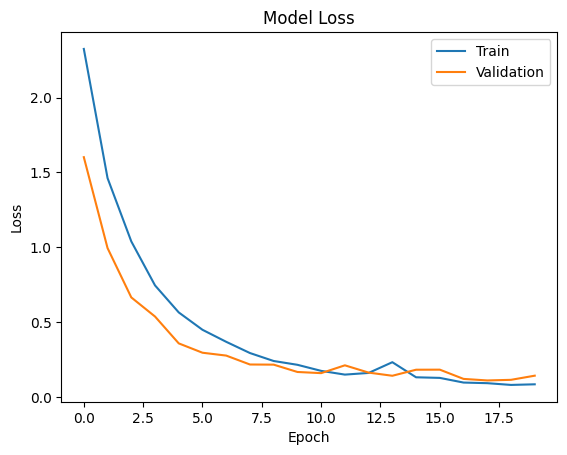

In [18]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy') 
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show() 

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model Loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
cnn_y_pred = cnn_model.predict(X_test) 
cnn_y_pred = np.argmax(cnn_y_pred, axis = -1)
print(classification_report(y_test, cnn_y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        38
           1       0.99      0.99      0.99       171
           2       0.92      0.99      0.95       121

    accuracy                           0.96       330
   macro avg       0.97      0.91      0.93       330
weighted avg       0.96      0.96      0.96       330



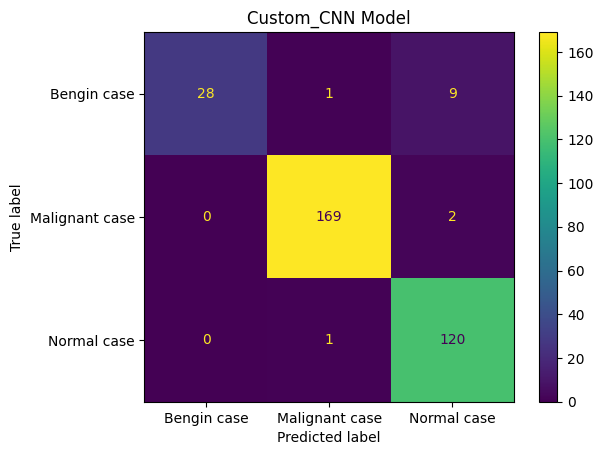

In [ ]:
cm = metrics.confusion_matrix(y_test, cnn_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = {'Bengin case':0, 'Malignant case':1, 'Normal case':2})

cm_display.plot()
plt.title("Custom_CNN Model")
plt.show()

In [ ]:
_ = cnn_model(tf.zeros((1, image_size, image_size, 3)))  # Builds the model with dummy input
feature_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

In [ ]:
feature_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 110, 110, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 54, 54, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 27, 27, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,984 (398.38 KB)

 Trainable params: 101,984 (398.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
feature_extractor = feature_model.predict(X_train) # extract feature from X_train

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


In [ ]:
Rf_X_train = feature_extractor # store it in a new variable to train RF

RF_model = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, min_samples_split = 2,
                                   max_depth = 100, max_features = 'sqrt', random_state=7)
RF_model.fit(Rf_X_train, y_train) # Training the RF model with the extracted feature

RandomForestClassifier(max_depth=100, random_state=7)

In [ ]:
# Extract features from test data
Rf_X_test = feature_model.predict(X_test)

# Make predictions on the test data
Rf_y_pred = RF_model.predict(Rf_X_test)

# Evaluate the model performance (e.g., accuracy)
print(classification_report(y_test, Rf_y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        38
           1       0.98      1.00      0.99       171
           2       0.95      0.98      0.97       121

    accuracy                           0.97       330
   macro avg       0.98      0.93      0.95       330
weighted avg       0.97      0.97      0.97       330



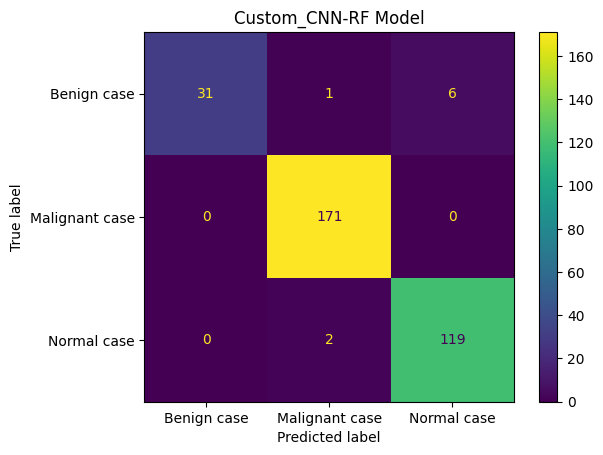

In [ ]:
cm = metrics.confusion_matrix(y_test, Rf_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = {'Benign case':0, 'Malignant case':1, 'Normal case':2})

cm_display.plot()
plt.title("Custom_CNN-RF Model")
plt.show()

In [ ]:
# Save the model architecture and weights to a HDF5 file
feature_model.save('/path/to/folder/custom_cnn_feature_extractor_finale.h5')
joblib.dump(RF_model, '/path/to/folder/RF_model_finale.pkl')

['/path/to/folder/RF_model_finale.pkl']